# Model performance on test set

First we show a variety of linear models, then DeepMRPA

Points in the scatter plot are weighted by 10^ weight used in training
and colored by their weight

In [1]:
from load_data import get_data
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import SGDRegressor
import dragonn

%matplotlib inline

In [2]:
X_train, X_valid, X_test, y_train, y_valid, y_test, w_train, w_valid, w_test = get_data()

/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [3]:
TASKS = ['HepG2 - minP', 'K562 - minP', 'HepG2 - SV40P', 'K562 - SV40P']

In [4]:
def kmerize(X, k):
    """
    Returns np.array of kmer counts corresponding to given seq
    """
    X = X.reshape(-1, 4, 145).swapaxes(1, 2).argmax(axis = 2)
    bases = ['00', '01', '10', '11']
    counts = []
    for seq in X:
        binary_seq = ''.join(map(lambda x: bases[x], seq))
        count = np.zeros((4**k,), dtype = int)
        for i in range(0, len(seq) - k + 1):
            count[int(binary_seq[i*2:(i+k)*2], 2)] += 1
        counts += [count]
    return np.vstack(counts)

Xk_train = kmerize(X_train, 6)
Xk_test = kmerize(X_test, 6)

In [24]:
def plot_predictions(models, name):
    for task, model in enumerate(models):
        ax = plt.subplot(111)
        mse = sum([(i-j) **2 for i, j in zip(model.predict(Xk_test), y_test[:, task])]) / y_test[:, task].shape[0]
        plt.scatter(model.predict(Xk_test), y_test[:, task], s=map(lambda x: 10 ** (x), w_test), c = w_test, lw = 0)
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(0.95, 0.05, "MSE = {}".format(str(mse)[:7]), transform=ax.transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)
        
        plt.xlabel("Model Predictions")
        plt.ylabel("Normalized MPRA Output")
        plt.title("{} for {} task".format(name, TASKS[task]))
        plt.show()

In [6]:
sgd_models = []
for task in range(y_train.shape[1]):
    sgd_models += [SGDRegressor().fit(Xk_train, y_train[:, task])]#, sample_weight = w_train)]

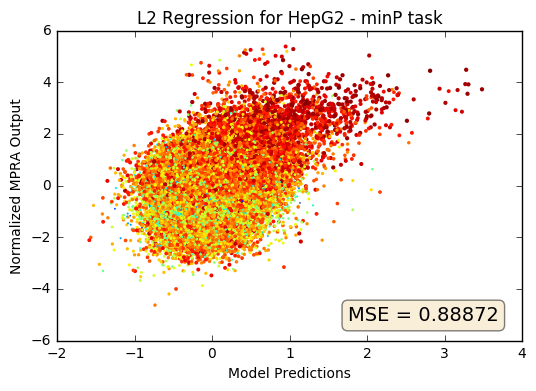

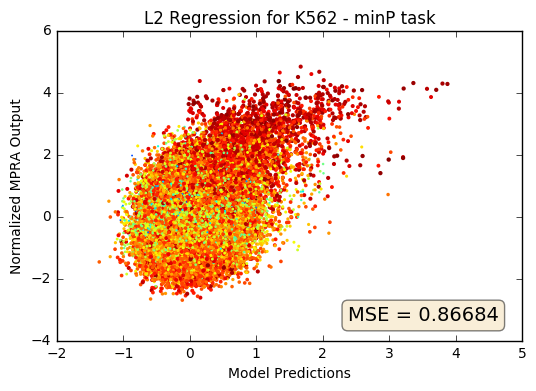

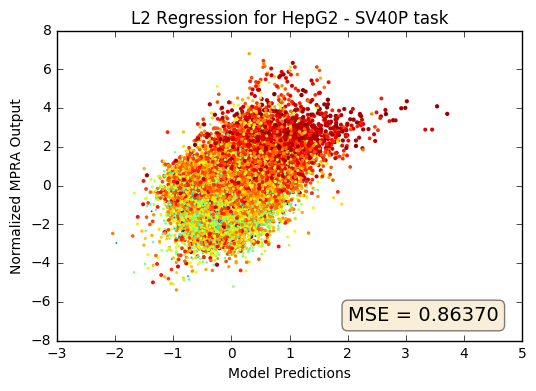

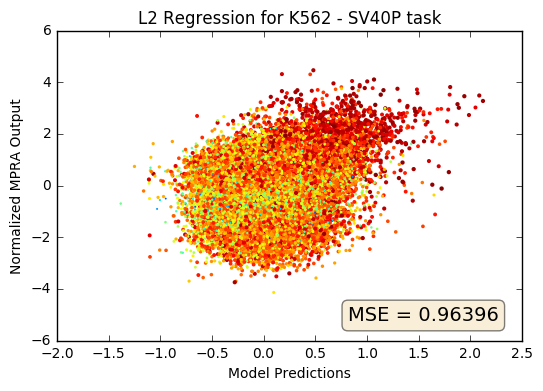

In [25]:
plot_predictions(sgd_models, 'L2 Regression')

In [8]:
elastic_net_models = []
for task in range(y_train.shape[1]):
    elastic_net_models += [SGDRegressor(penalty = 'elasticnet').fit(Xk_train, y_train[:, task])]#, sample_weight = w_train)]

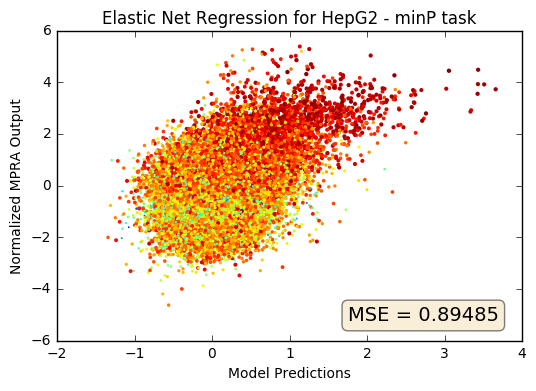

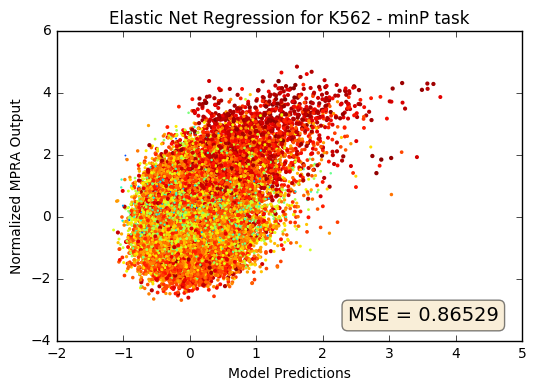

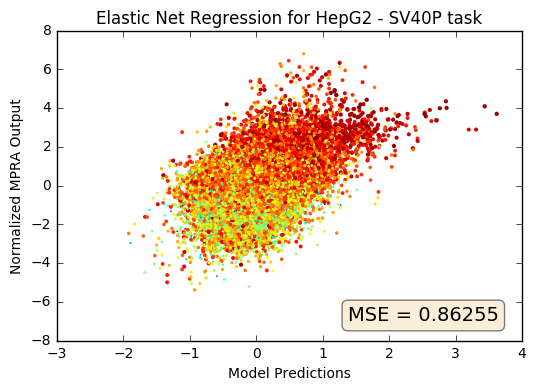

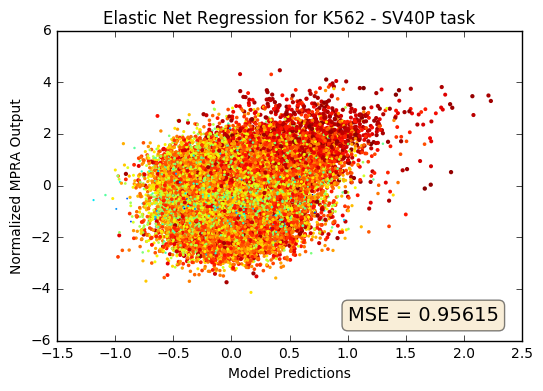

In [26]:
plot_predictions(elastic_net_models, 'Elastic Net Regression')

In [11]:
lasso_models = []
for task in range(y_train.shape[1]):
    lasso_models += [SGDRegressor(penalty = 'l1').fit(Xk_train, y_train[:, task])]#, sample_weight = w_train)]

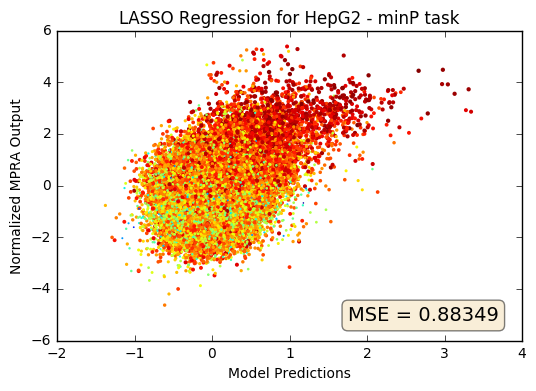

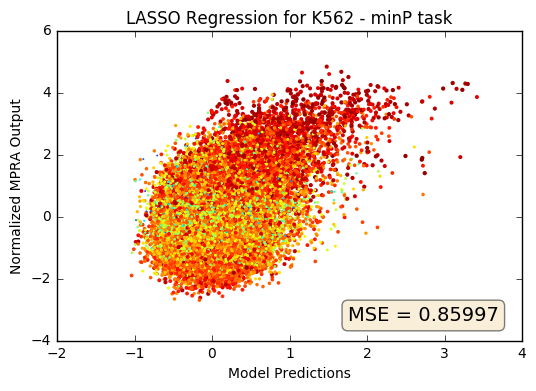

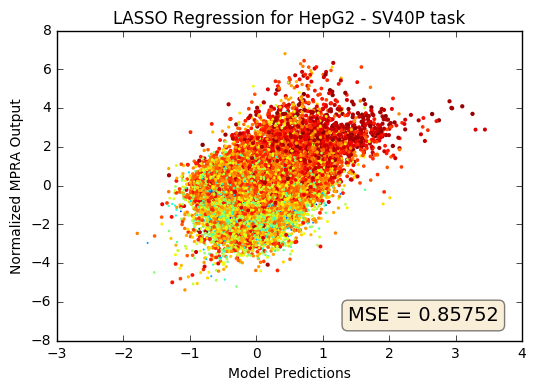

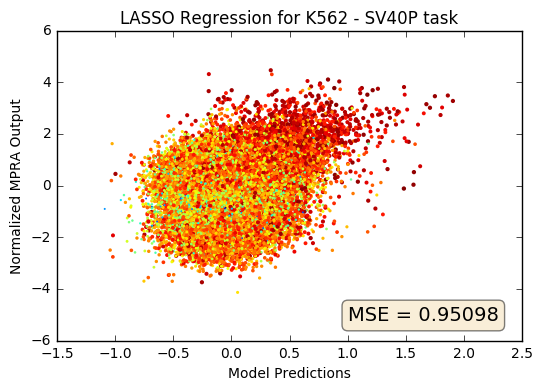

In [27]:
plot_predictions(lasso_models, 'LASSO Regression')

# Deep MRPA

In [13]:
from models import SequenceDNN_Regression
deep_model = SequenceDNN_Regression.load(
    'models/100n1_100n2_8w1_15w2.arch.json',
    'models/100n1_100n2_8w1_15w2.weights.h5')

/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5005)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


-1.38653853578


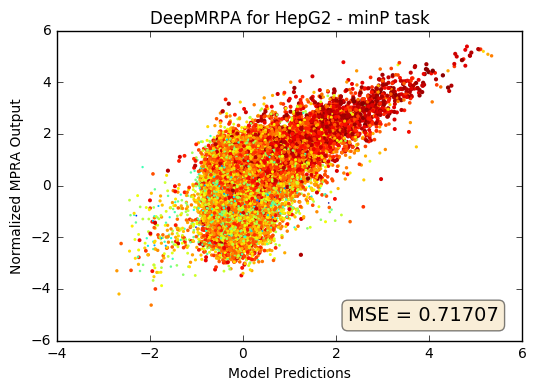

-1.48576215656


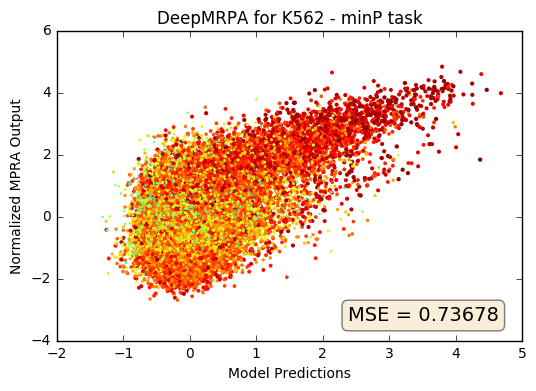

-1.0945074459


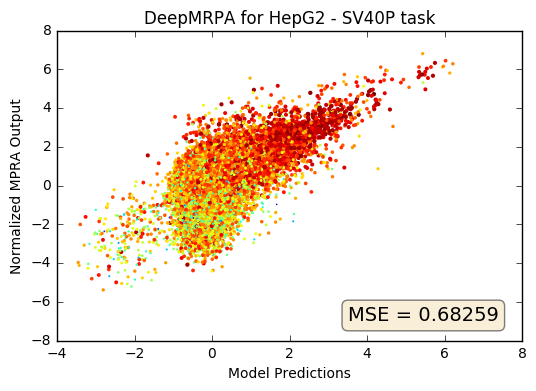

-4.97539436514


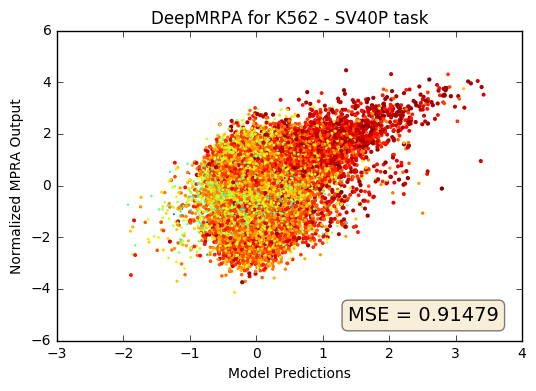

In [28]:
predictions = deep_model.predict(X_test)
for task in range(4):
    print metrics.r2_score(predictions[:, task], y_test[:, task])
    mse = sum([(i-j) **2 for i, j in zip(predictions2[:, task], y_test[:, task])]) / y_test[:, task].shape[0]
    ax = plt.subplot(111)
    sc = plt.scatter(predictions[:, task], y_test[:, task], s=map(lambda x: 10 ** (x), w_test), c = w_test, lw = 0)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.95, 0.05, "MSE = {}".format(str(mse)[:7]), transform=ax.transAxes, fontsize=14,
                verticalalignment='bottom', horizontalalignment='right', bbox=props)
        
    plt.xlabel("Model Predictions")
    plt.ylabel("Normalized MPRA Output")
    plt.title("{} for {} task".format('DeepMRPA', TASKS[task]))
    plt.show()

In [15]:
from models import SequenceDNN_Regression
unweighted_model = SequenceDNN_Regression.load(
    'models/100n1_100n2_8w1_15w2_unweighted.arch.json',
    'models/100n1_100n2_8w1_15w2_unweighted.weights.h5')

-1.3639770475


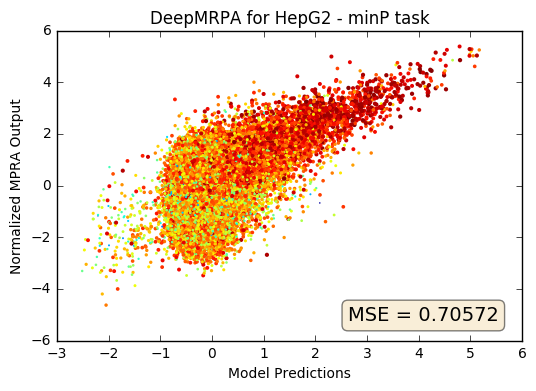

-1.6103822998


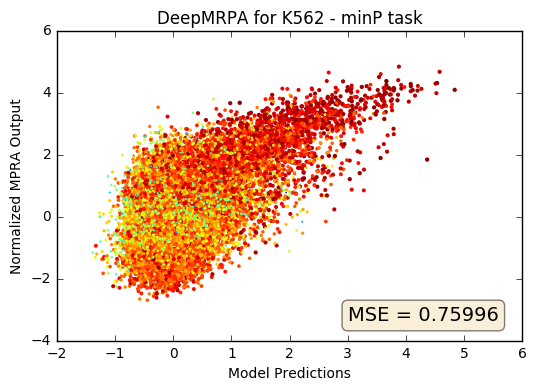

-1.07687900271


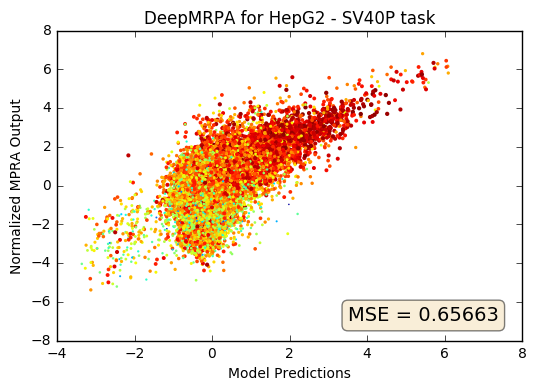

-5.09403667655


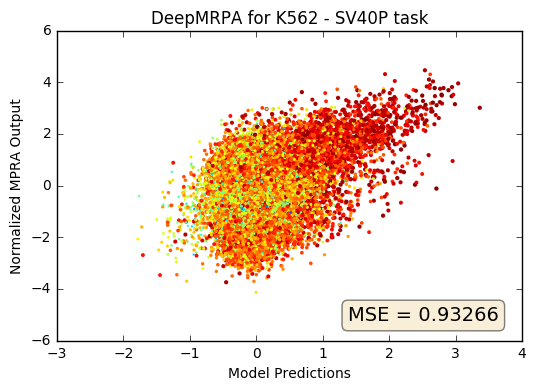

In [19]:
predictions2 = unweighted_model.predict(X_test)
for task in range(4):
    print metrics.r2_score(predictions2[:, task], y_test[:, task])
    mse = (sum([(i-j) **2 * k for i, j, k in zip(predictions2[:, task], y_test[:, task], w_test)]) / sum(w_test))
    #mse = sum([(i-j) **2 for i, j in zip(predictions2[:, task], y_test[:, task])]) / y_test[:, task].shape[0]
    ax = plt.subplot(111)
    sc = plt.scatter(predictions2[:, task], y_test[:, task], s=map(lambda x: 10 ** (x), w_test), c = w_test, lw = 0)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.95, 0.05, "MSE = {}".format(str(mse)[:7]), transform=ax.transAxes, fontsize=14,
                verticalalignment='bottom', horizontalalignment='right', bbox=props)
        
    plt.xlabel("Model Predictions")
    plt.ylabel("Normalized MPRA Output")
    plt.title("{} for {} task".format('DeepMRPA', TASKS[task]))
    plt.show()

In [17]:
from models import SequenceDNN_Regression
unweighted_model2 = SequenceDNN_Regression.load(
    'models/100n1_100n2_8w1_15w2_unweighted2.arch.json',
    'models/100n1_100n2_8w1_15w2_unweighted2.weights.h5')
predictions3 = unweighted_model2.predict(X_test)

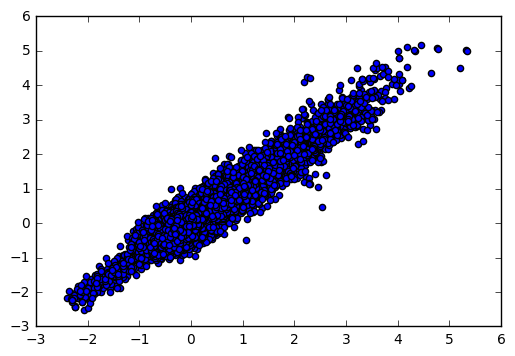

In [20]:
plt.scatter(predictions3[:, 0], predictions2[:, 0])
plt.show()